In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import os

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
# Define dataset paths
train_dir = '/content/drive/MyDrive/***DataSet_Thesis2024/new2024_orgImg/train'
val_dir = '/content/drive/MyDrive/***DataSet_Thesis2024/new2024_orgImg/val'
model_save_path = '/content/drive/MyDrive/***DataSet_Thesis2024/modeloutput/ViT/30_Vit_Sobel_clean_vs_unclean.pth'  # Replace with desired save path

In [4]:
# Parameters
img_size = 224
batch_size = 16
epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/30, Train Loss: 0.1418, Train Acc: 95.06%, Val Loss: 0.0443, Val Acc: 98.62%
Epoch 2/30, Train Loss: 0.0378, Train Acc: 99.06%, Val Loss: 0.0052, Val Acc: 99.88%
Epoch 3/30, Train Loss: 0.0611, Train Acc: 98.31%, Val Loss: 0.0068, Val Acc: 99.94%
Epoch 4/30, Train Loss: 0.0520, Train Acc: 98.88%, Val Loss: 0.0618, Val Acc: 97.06%
Epoch 5/30, Train Loss: 0.0381, Train Acc: 99.06%, Val Loss: 0.0330, Val Acc: 98.94%
Epoch 6/30, Train Loss: 0.0023, Train Acc: 99.94%, Val Loss: 0.0085, Val Acc: 99.81%
Epoch 7/30, Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 0.0056, Val Acc: 99.88%
Epoch 8/30, Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 0.0056, Val Acc: 99.88%
Epoch 9/30, Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 0.0055, Val Acc: 99.88%
Epoch 10/30, Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 0.0055, Val Acc: 99.88%
Epoch 11/30, Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 0.0055, Val Acc: 99.88%
Epoch 12/30, Train Loss: 0.0000, Train Acc: 100.00%, Val L

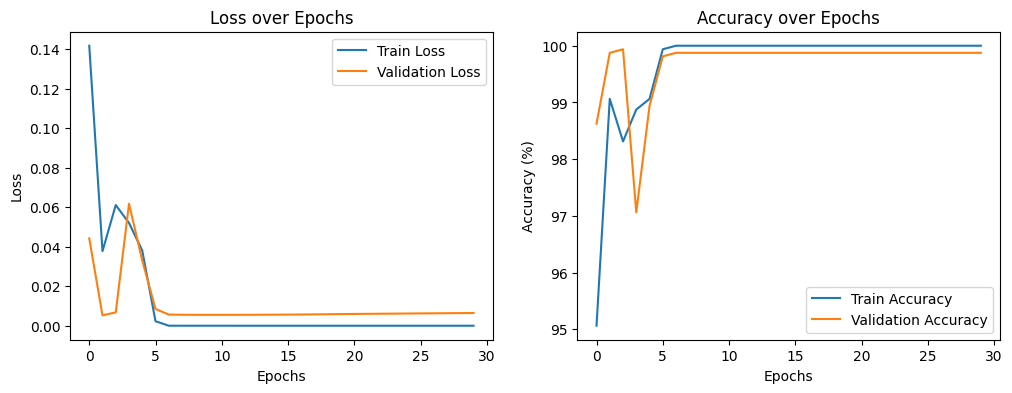

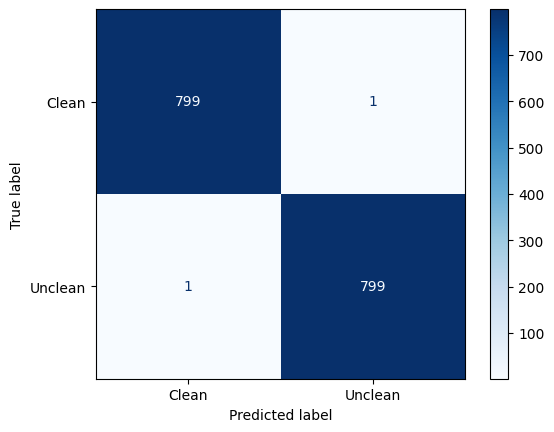

Classification Report:
              precision    recall  f1-score   support

       Clean   0.998750  0.998750  0.998750       800
     Unclean   0.998750  0.998750  0.998750       800

    accuracy                       0.998750      1600
   macro avg   0.998750  0.998750  0.998750      1600
weighted avg   0.998750  0.998750  0.998750      1600



In [6]:
# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define Vision Transformer (ViT) Model
from timm import create_model

vit_model = create_model('vit_base_patch16_224', pretrained=True, num_classes=2)
vit_model = vit_model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)

# Train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100. * correct / total)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100. * correct / total)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

train_losses, val_losses, train_accuracies, val_accuracies = train_model(vit_model, train_loader, val_loader, criterion, optimizer, epochs)

# Plot metrics
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

# Evaluate and plot confusion matrix
def evaluate_model(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

true_labels, predictions = evaluate_model(vit_model, val_loader)

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap='Blues')
plt.show()

# Classification report
print("Classification Report:")
report = classification_report(true_labels, predictions, target_names=train_dataset.classes,digits=6)
print(report)

# Save the model
# os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved successfully to {model_save_path}")
